# Patron de Puntos

In [9]:
import warnings
warnings.filterwarnings('ignore')

import descartes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import pysal
import seaborn as sbn
import contextily as ctx
from sklearn.cluster import KMeans, DBSCAN
from matplotlib_map_utils.core.north_arrow import NorthArrow, north_arrow
from matplotlib_map_utils.core.scale_bar import ScaleBar, scale_bar
import plotly.express as px
import plotly.graph_objects as go
pd.set_option('display.max_columns', None)


In [2]:
gdf = gpd.read_file("https://github.com/algarciach/AnalisisGeoespacial/raw/main/Covid19_model/Data/covid19_municipios_antioquia.gpkg")
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   codigo_municipio     125 non-null    object  
 1   nombre_municipio     125 non-null    object  
 2   codigo_subregion     125 non-null    object  
 3   nombre_subregion     125 non-null    object  
 4   area_municipio       125 non-null    float64 
 5   altitud              125 non-null    float64 
 6   temperatura          125 non-null    float64 
 7   humedad_relativa     125 non-null    float64 
 8   poblacion            125 non-null    int64   
 9   densidad             125 non-null    float64 
 10  muertes_covid19      125 non-null    int64   
 11  recuperados_covid19  125 non-null    int64   
 12  cfr                  125 non-null    float64 
 13  geometry             125 non-null    geometry
dtypes: float64(6), geometry(1), int64(3), object(4)
memory usage: 13.8

### Centroides

In [3]:
points_covid19_antioquia = gdf.copy()
points_covid19_antioquia["geometry"] = gdf.geometry.centroid
points_covid19_antioquia = points_covid19_antioquia.set_geometry("geometry")
print(points_covid19_antioquia.crs)

EPSG:4326


In [4]:
points_covid19_antioquia.info()
points_covid19_antioquia.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   codigo_municipio     125 non-null    object  
 1   nombre_municipio     125 non-null    object  
 2   codigo_subregion     125 non-null    object  
 3   nombre_subregion     125 non-null    object  
 4   area_municipio       125 non-null    float64 
 5   altitud              125 non-null    float64 
 6   temperatura          125 non-null    float64 
 7   humedad_relativa     125 non-null    float64 
 8   poblacion            125 non-null    int64   
 9   densidad             125 non-null    float64 
 10  muertes_covid19      125 non-null    int64   
 11  recuperados_covid19  125 non-null    int64   
 12  cfr                  125 non-null    float64 
 13  geometry             125 non-null    geometry
dtypes: float64(6), geometry(1), int64(3), object(4)
memory usage: 13.8

,codigo_municipio,nombre_municipio,codigo_subregion,nombre_subregion,area_municipio,altitud,temperatura,humedad_relativa,poblacion,densidad,muertes_covid19,recuperados_covid19,cfr,geometry
0,05001,MEDELLIN,01,VALLE DE ABURRA,374.834005,2059.003077,18.203481,80.582299,2616335,6979.983054,10354,537729,1.889130,POINT (-75.61104 6.25759)
1,05002,ABEJORRAL,07,ORIENTE,507.141095,1947.128522,17.845754,80.265871,21468,42.331415,24,579,3.980100,POINT (-75.43847 5.80373)
2,05004,ABRIAQUI,06,OCCIDENTE,296.894050,2371.335448,15.912880,85.717115,2855,9.616225,1,78,1.265823,POINT (-76.08598 6.62755)
3,05021,ALEJANDRIA,07,ORIENTE,128.932153,1545.100614,20.538783,80.036523,4955,38.431065,6,176,3.296703,POINT (-75.0906 6.36553)
4,05030,AMAGA,08,SUROESTE,84.132477,1513.740970,21.093243,78.477931,32412,385.249562,54,1440,3.614458,POINT (-75.708 6.03292)


Para efectos del análisis de eventos, se construye una variable binaria que indica la ocurrencia de un evento crítico. Esta toma el valor de 1 si la tasa de letalidad (CFR) supera el umbral del 3% y 0 en caso contrario.

In [6]:
points_covid19_antioquia["evento_CFR"] = points_covid19_antioquia["cfr"].apply(lambda x: 1 if x > 3 else 0)
points_covid19_antioquia.info()
points_covid19_antioquia["evento_CFR"].value_counts()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   codigo_municipio     125 non-null    object  
 1   nombre_municipio     125 non-null    object  
 2   codigo_subregion     125 non-null    object  
 3   nombre_subregion     125 non-null    object  
 4   area_municipio       125 non-null    float64 
 5   altitud              125 non-null    float64 
 6   temperatura          125 non-null    float64 
 7   humedad_relativa     125 non-null    float64 
 8   poblacion            125 non-null    int64   
 9   densidad             125 non-null    float64 
 10  muertes_covid19      125 non-null    int64   
 11  recuperados_covid19  125 non-null    int64   
 12  cfr                  125 non-null    float64 
 13  geometry             125 non-null    geometry
 14  evento_CFR           125 non-null    int64   
dtypes: float64(6), 

evento_CFR
0    67
1    58
Name: count, dtype: int64

In [7]:
# + tags=["hide-output"]
%pip install geopandas
%pip install plotly
%pip install matplotlib-map-utils

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Visualization

### Dots on Map

In [67]:
# Extract coordinates from geometry
points_covid19_antioquia["longitude"] = points_covid19_antioquia.geometry.x
points_covid19_antioquia["latitude"] = points_covid19_antioquia.geometry.y

# Filter points with evento_CFR > 3
CFR3_points = points_covid19_antioquia[points_covid19_antioquia["evento_CFR"] == 1]

In [111]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter_mapbox(
    CFR3_points,
    lat=CFR3_points.latitude,
    lon=CFR3_points.longitude,
    size_max=15,
    zoom=6.3,
    height=600
)

fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_zoom=6.3,
    mapbox_center={"lat": 6.25, "lon": -75.5},
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
    mapbox=dict(
        bearing=0,
        pitch=0,
        center=dict(lat=6.25, lon=-75.5)
    )
)

fig.show()


### Municipios con CFR > 3

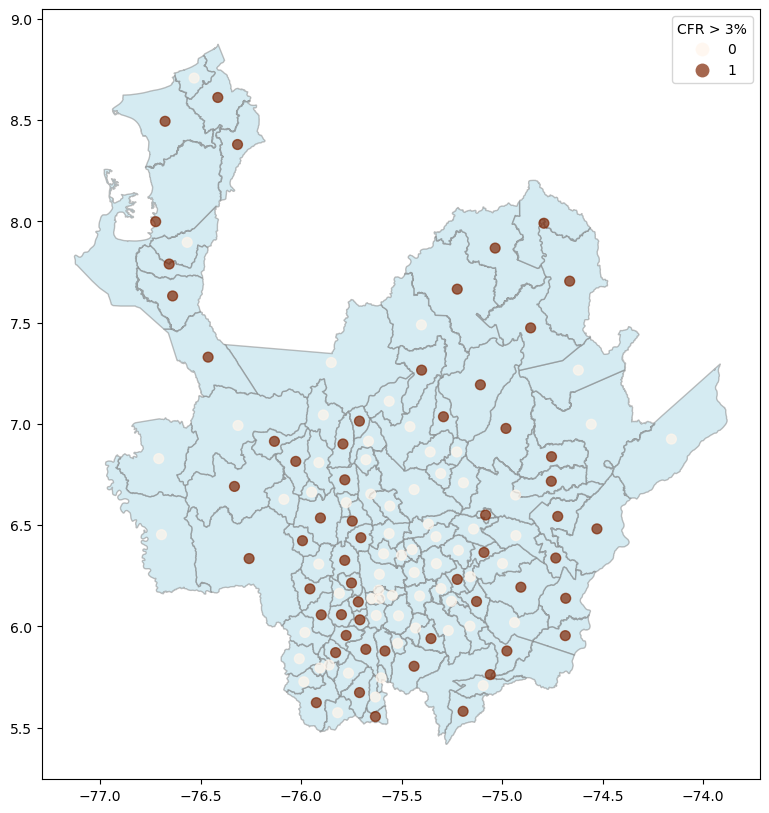

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='lightblue', edgecolor='grey', alpha=0.5)
points_covid19_antioquia.plot(
    ax=ax, column='evento_CFR', categorical=True, legend=True,
    legend_kwds={'title': 'CFR > 3%'},
    cmap='Oranges', markersize=50, alpha=0.7
    )
plt.show()

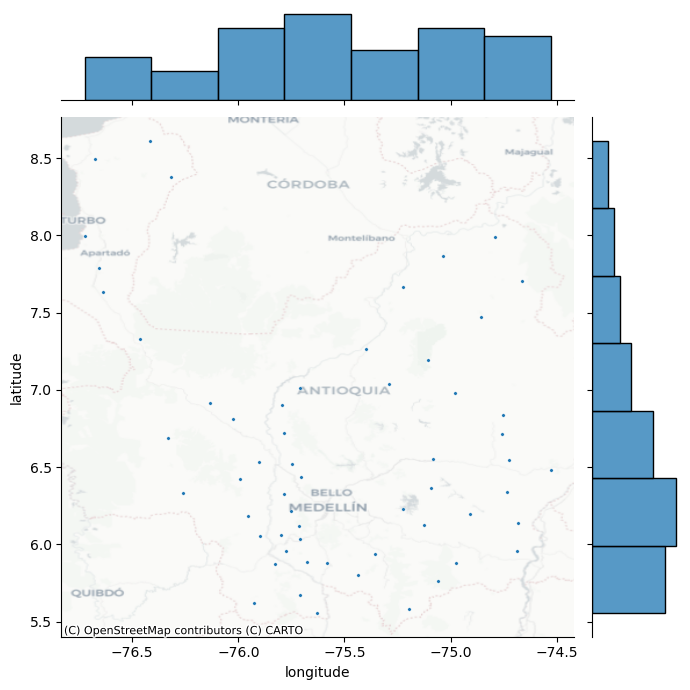

In [80]:
import contextily as ctx
joint_axes = sbn.jointplot(x='longitude', y='latitude', data=CFR3_points, s=6, height=7)
ctx.add_basemap(
    joint_axes.ax_joint, crs=CFR3_points.crs,
    source=ctx.providers.CartoDB.Positron)

### Irregular lattices

Usaremos las areas de las subregiones para determinar la intensidad de puntos en las zonas

In [81]:
subregiones_antioquia =  gdf.dissolve(by="codigo_subregion", as_index=False).reset_index()

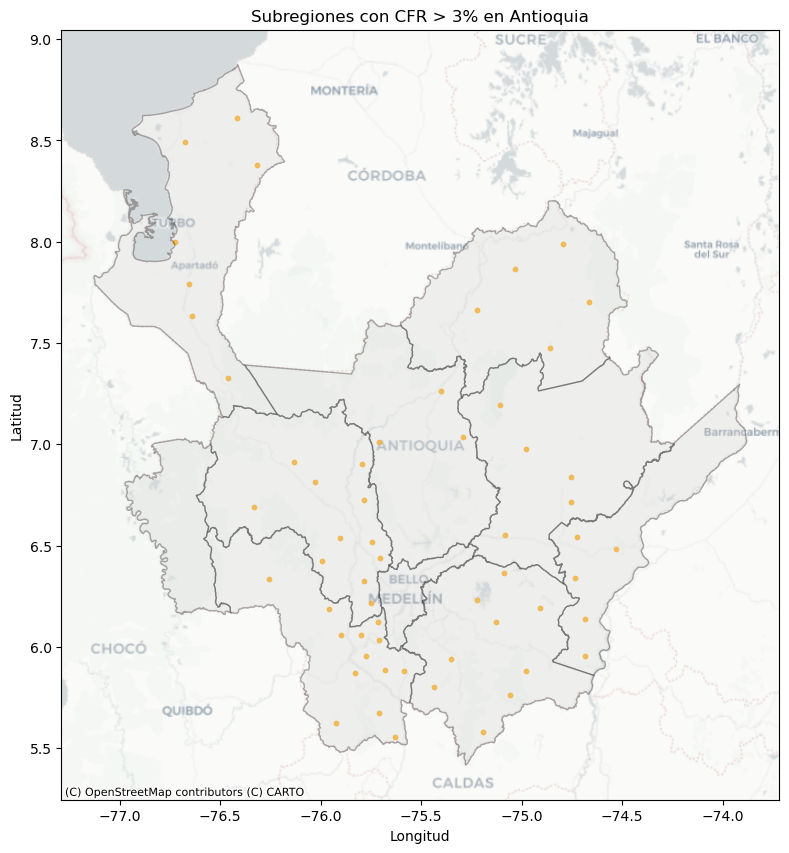

In [94]:
ax = CFR3_points.plot.scatter(
    x='longitude', y='latitude', s=10, 
    c='orange', alpha=0.8, figsize=(10, 10)
)
subregiones_antioquia.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.3)
ax.set_title('Subregiones con CFR > 3% en Antioquia')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ctx.add_basemap(
    ax, crs=CFR3_points.crs,
    source=ctx.providers.CartoDB.Positron)
plt.show()


Determinar cuantos municipios con CFR > 3 por subregion

In [98]:
CFR3_points_by_subregion = CFR3_points.groupby('codigo_subregion').size().reset_index(name='count')

suberegiones = subregiones_antioquia.merge(
    CFR3_points_by_subregion, on='codigo_subregion', how='left'
)
suberegiones['count'] = suberegiones['count'].fillna(0)


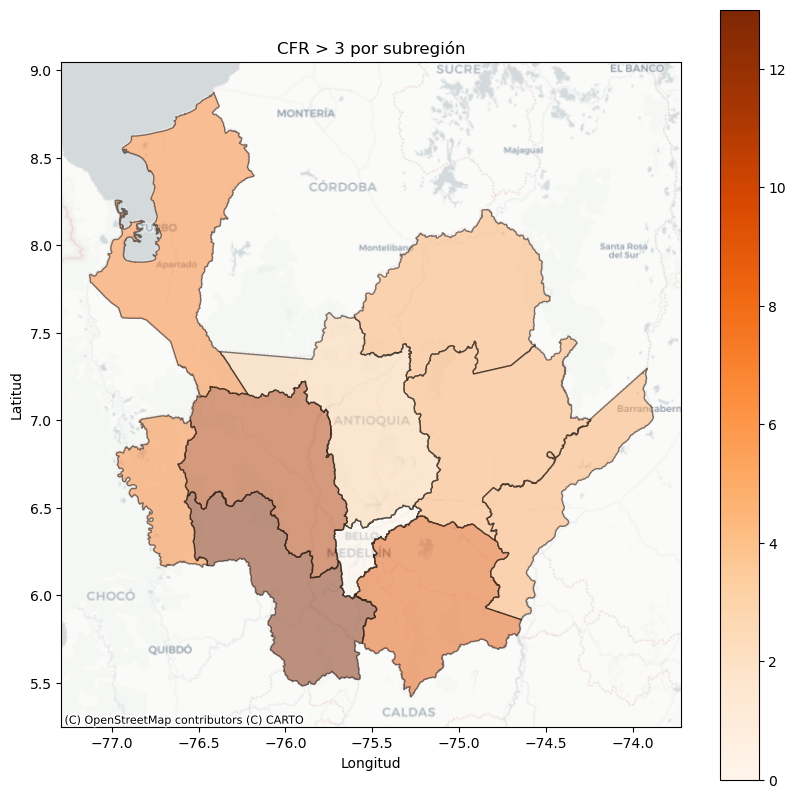

In [100]:
fig, ax = plt.subplots(figsize=(10, 10))
suberegiones.plot(
    ax=ax, column='count', cmap='Oranges', legend=True,
    edgecolor='black', alpha=0.5
)
ax.set_title('CFR > 3 por subregión')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ctx.add_basemap(
    ax, crs=suberegiones.crs,
    source=ctx.providers.CartoDB.Positron)
plt.show()

### Regular lattices: Hex-binning

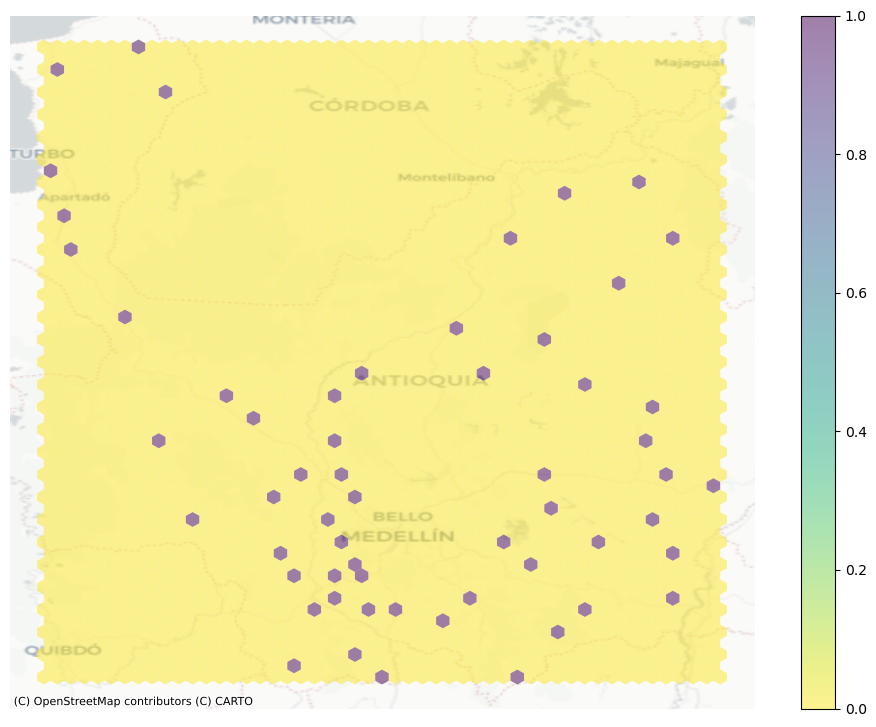

In [107]:
f, ax = plt.subplots(1, figsize=(12, 9))
hb = ax.hexbin(
    CFR3_points.longitude, CFR3_points.latitude,
    gridsize=50, 
    linewidths=0,
    alpha=0.5,
    cmap='viridis_r',
)

ctx.add_basemap(
    ax, crs="EPSG:4326",
    source=ctx.providers.CartoDB.Positron)

plt.colorbar(hb) 

ax.set_axis_off()   


### Kernel Density Estimation (KDE)

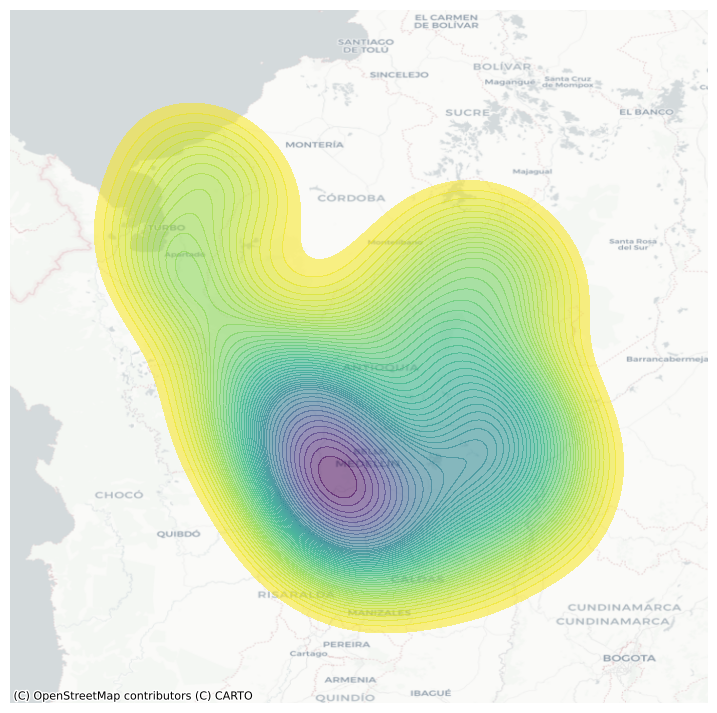

In [117]:
f, ax = plt.subplots(1, figsize=(9, 9))

sbn.kdeplot(
    x=CFR3_points.longitude, y=CFR3_points.latitude,
    fill=True, alpha=0.55, levels=50,
    cmap='viridis_r', ax=ax
)
ctx.add_basemap(
    ax, crs="EPSG:4326",
    source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
